# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [57]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [58]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [59]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [60]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [61]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [62]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [63]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [64]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [65]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [66]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [67]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [68]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [69]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [70]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [71]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [72]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [73]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [74]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [75]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [76]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [77]:
# https://gist.github.com/sebleier/554280

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [78]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████| 46071/46071 [01:00<00:00, 767.76it/s]


In [79]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

# [4] Featurization

## [4.4] Word2Vec

In [81]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [83]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [84]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = [];
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 46071/46071 [06:52<00:00, 111.63it/s]


46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [85]:

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [86]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████| 46071/46071 [1:24:11<00:00, 12.59it/s]


# [5] Assignment 4: Apply Naive Bayes

In [110]:
preprocessed_reviews.shape[0]

46071

In [87]:
import math

preprocessed_reviews = np.array(preprocessed_reviews) 
train_size = math.floor(preprocessed_reviews.shape[0] * 0.7)

#split the data set into train and test
preprocessed_reviews_train = preprocessed_reviews[: train_size]
preprocessed_reviews_test  =preprocessed_reviews[train_size : ]  
Score_train =final['Score'][: train_size ]
Score_test = final['Score'][train_size : ]
print(preprocessed_reviews_train.shape)
print(preprocessed_reviews_test.shape)

print(Score_train.shape)
print(Score_test.shape)
print(Score_train.value_counts())

(32249,)
(13822,)
(32249,)
(13822,)
1    27032
0     5217
Name: Score, dtype: int64


## BoW

In [88]:
count_vect = CountVectorizer(min_df=5) 

# BOW on Train data 
count_vect_train_data = count_vect.fit_transform(preprocessed_reviews_train)

# BOW on Test data  
count_vect_test_data = count_vect.transform(preprocessed_reviews_test)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)


print("the type of count vectorizer of train Preprocessed data",type(count_vect_train_data))
print("the type of count vectorizer of test Preprocessed data",type(count_vect_test_data))
print("the shape of out text BOW vectorizer on train data",count_vect_train_data.get_shape())
print("the shape of out text BOW vectorizer on test data",count_vect_test_data.get_shape())
print("the number of unique words ", count_vect_test_data.get_shape()[1])

some feature names  ['aa', 'abandon', 'abdominal', 'ability', 'able', 'abroad', 'absence', 'absent', 'absolute', 'absolutely']
the type of count vectorizer of train Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer of test Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer on train data (32249, 10293)
the shape of out text BOW vectorizer on test data (13822, 10293)
the number of unique words  10293


## bi-gram, tri-gram and n-gram

In [89]:


n_count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)

# bi-gram BOW on Train data and Test data 
n_count_vect_train_data = n_count_vect.fit_transform(preprocessed_reviews_train) 
n_count_vect_test_data = n_count_vect.transform(preprocessed_reviews_test)


print("some feature names ", n_count_vect.get_feature_names()[:10])
print('='*50)


print("the type of count vectorizer of train Preprocessed data",type(n_count_vect_train_data))
print("the type of count vectorizer of test Preprocessed data",type(n_count_vect_test_data))
print("the shape of out text bi gram BOW vectorizer on train data",n_count_vect_train_data.get_shape())
print("the shape of out text bi gram BOW vectorizer on test data",n_count_vect_test_data.get_shape())
print("the number of unique words ",n_count_vect_train_data.get_shape()[1])

some feature names  ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
the type of count vectorizer of train Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer of test Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text bi gram BOW vectorizer on train data (32249, 19207)
the shape of out text bi gram BOW vectorizer on test data (13822, 19207)
the number of unique words  19207


## TF-IDF

In [90]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10 )

# n-gram TfIdf on Train and Test data 
tfIdf_vect_train_data = tf_idf_vect.fit_transform(preprocessed_reviews_train) 
tfIdf_vect_test_data = tf_idf_vect.transform(preprocessed_reviews_test)

print("some feature names ", tf_idf_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer of train Preprocessed data",type(tfIdf_vect_train_data))
print("the type of count vectorizer of test Preprocessed data",type(tfIdf_vect_test_data))
print("the shape of out text n-gram TfIdf vectorizer on train data",tfIdf_vect_train_data.get_shape())
print("the shape of out text n-gram TfIdf vectorizer on test data",tfIdf_vect_test_data.get_shape())
print("the number of unique words ",tfIdf_vect_train_data.get_shape()[1])

some feature names  ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
the type of count vectorizer of train Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer of test Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text n-gram TfIdf vectorizer on train data (32249, 19207)
the shape of out text n-gram TfIdf vectorizer on test data (13822, 19207)
the number of unique words  19207


# Applying Multinomial Naive Bayes

In [91]:
# Functions for naive bayes accuracy
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

#Function to return Optimal value of alpha and Draw plot of area under roc curve vs alpha-
def NaiveBayes_accuracy(Train_data ,Score_train ):
    #possible number of alpha
    alphas =  np.array([0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,30,100,300,1000])
    param_grid = dict(alpha = alphas)
    
    NB_Optimal = MultinomialNB()
    grid = GridSearchCV(NB_Optimal, param_grid=param_grid,scoring='roc_auc',cv=5,  n_jobs=-1)
    grid_result = grid.fit(Train_data , Score_train)
    
    # summarize results
    CV_mean = grid_result.cv_results_['mean_test_score']
    Train_mean = grid_result.cv_results_['mean_train_score']
    
   
    # Plot graph between grid cross validation result and number of neighbors
    plt.plot(np.log10(alphas), CV_mean ,label='AUC of CV data against Alpha' , marker = '*')
    plt.plot(np.log10(alphas) , Train_mean , label='AUC of train data against Alpha' , marker = '*')
    plt.title("Area under Roc Curve vs alpha")
    plt.xlabel('alpha')
    plt.ylabel('Area')
    plt.legend(loc="lower right")
    plt.show()

# Function to  plot graph on area under roc curve on test and train data and print confusion matrix
def plot_Graph(alpha, Train_data, Train_label, Test_data, Test_label):
    #Train KNN on optimal parameter
    NB_Optimal = MultinomialNB(alpha = alpha)
    # fitting the model
    NB_Optimal.fit(Train_data, Train_label)

    #predict the probability of Train data and test data from model
    train_log_proba = NB_Optimal.predict_log_proba(Train_data)
    test_log_proba =  NB_Optimal.predict_log_proba(Test_data)
    
    #Calculate the Class 
    train_pred = np.argmax(train_log_proba, axis=1) 
    test_pred =  np.argmax(test_log_proba, axis=1)
    
    #Compute fpr and tpr from the predicted label and  True label of train data and test data
    fpr_train, tpr_train,_ = roc_curve(Train_label, train_pred)
    fpr_test, tpr_test,_ = roc_curve(Test_label, test_pred)
    
    # Compute area under roc curve
    area_train = auc(fpr_train, tpr_train)
    area_test = auc(fpr_test, tpr_test)
    
    lw =2
    plt.plot(fpr_test, tpr_test, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
    plt.plot(fpr_train, tpr_train, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Area Under Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
    
    # Confusion matrix for train data
    
    plt.figure()
    cm = confusion_matrix(Train_label, train_pred)
    class_label = ["negative", "positive"]
    df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm_train , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for Train data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
     # Confusion matrix for test data
    
    plt.figure()
    cm = confusion_matrix(Test_label, test_pred)
    class_label = ["negative", "positive"]
    df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

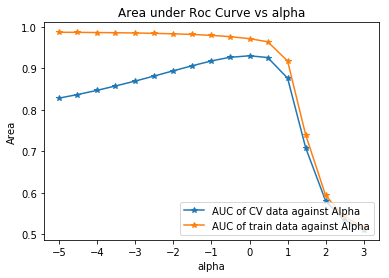

In [92]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings("ignore")

# Find optimal value of aplha
NaiveBayes_accuracy(n_count_vect_train_data , Score_train)

## Observations -->
    
    Optimal alpha for BoW = 1

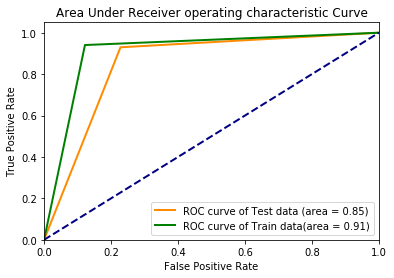

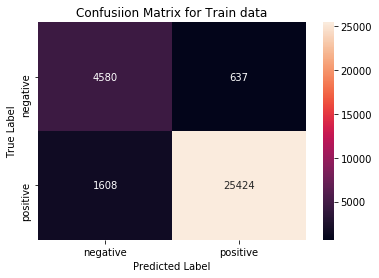

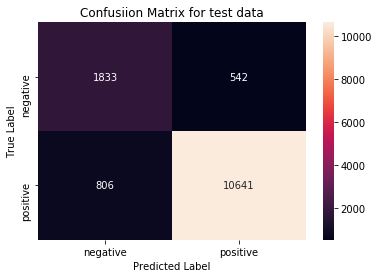

In [93]:
# By looking at the validation and traing curve we can say that
BOW_optimal_alpha = 1.0
#Plot the graph on area under roc curve on test and train data and print confusion matrix
plot_Graph(BOW_optimal_alpha , n_count_vect_train_data, Score_train, n_count_vect_test_data, Score_test)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [94]:
# Please write all the code with proper documentation
# Train model with optimal value of alpha
NB_optimal = MultinomialNB(alpha = BOW_optimal_alpha)
    
# fitting the model
NB_optimal.fit(n_count_vect_train_data, Score_train)

# Top 10 positive  Features After Naive Bayes
pos_class_prob_sorted = NB_optimal.feature_log_prob_[0, :].argsort()
print(np.take(n_count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

['zukes' 'peterson' 'personally prefer' 'cut top' 'personal thing'
 'periods time' 'perfectly seasoned' 'perfectly balanced' 'daily diet'
 'daily treat']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [95]:
# Please write all the code with proper documentation
neg_class_prob_sorted = NB_optimal.feature_log_prob_[1,:].argsort()
print(np.take(n_count_vect.get_feature_names(), neg_class_prob_sorted[:10]))

['food bank' 'two stars' 'give zero' 'threw rest' 'return product'
 'dogs died' 'extremely disappointed' 'absolutely horrible'
 'false advertising' 'get refund']


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

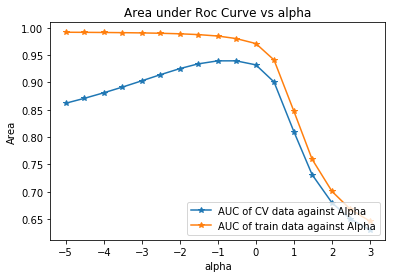

In [96]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings("ignore")

# Find optimal value of aplha
NaiveBayes_accuracy(tfIdf_vect_train_data , Score_train)

## Observations -->
    Optimal alpha for TF-IDF = 0.1

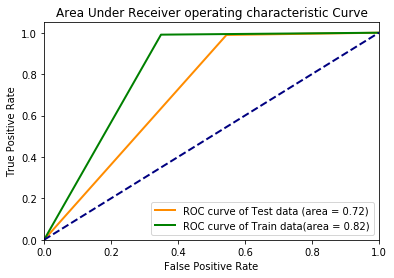

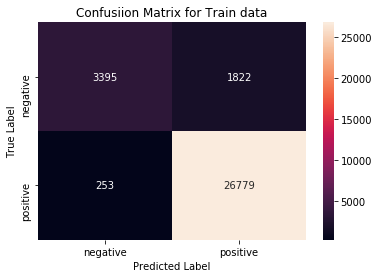

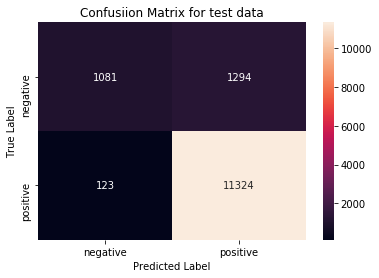

In [97]:
# Please write all the code with proper documentation
# By looking at the validation and traing curve we can say that
tfIdf_optimal_alpha = 0.1

#Plot the graph on area under roc curve on test and train data and print confusion matrix
plot_Graph(tfIdf_optimal_alpha , tfIdf_vect_train_data , Score_train, tfIdf_vect_test_data , Score_test)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [98]:
# Train model with optimal value of alpha
NB_optimal_TfIdf = MultinomialNB(alpha = tfIdf_optimal_alpha)
    
# fitting the model
NB_optimal_TfIdf.fit(tfIdf_vect_train_data , Score_train)

# Top 10 positive  Features After Naive Bayes
pos_class_prob_sorted = NB_optimal_TfIdf.feature_log_prob_[0,:].argsort()
print(np.take(n_count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

['zukes' 'perfect every' 'perfect consistency' 'perfect blend'
 'crunch flavor' 'crunchy like' 'crunchy snack' 'peppercorns' 'peppercorn'
 'pepper sauce']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [99]:
# Please write all the code with proper documentation
# Top 10 negative Features After Naive Bayes
neg_class_prob_sorted = NB_optimal_TfIdf.feature_log_prob_[1, :].argsort()
print(np.take(n_count_vect.get_feature_names(), neg_class_prob_sorted[:10]))


['absolutely horrible' 'threw rest' 'extremely disappointed' 'no response'
 'tasted old' 'give zero' 'huge disappointment' 'return product'
 'dogs died' 'get refund']


# [6] Conclusions

In [102]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Algorithm", "Optimal alpha" , "Train_data_AUC", "CrossValidation_data_AUC", "Test_data_AUC"]
x.add_row(["Naive Bayes(BOW)" , 1.0 , 0.91 , 0.91 , 0.85 ])
x.add_row(["Naive Bayes(TfIdf)" , 0.1 , 0.82 , 0.94 , 0.72 ])

print(x)

+--------------------+---------------+----------------+--------------------------+---------------+
|     Algorithm      | Optimal alpha | Train_data_AUC | CrossValidation_data_AUC | Test_data_AUC |
+--------------------+---------------+----------------+--------------------------+---------------+
|  Naive Bayes(BOW)  |      1.0      |      0.91      |           0.91           |      0.85     |
| Naive Bayes(TfIdf) |      0.1      |      0.82      |           0.94           |      0.72     |
+--------------------+---------------+----------------+--------------------------+---------------+
